In [1]:
import sys
import os
# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))

import torch
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# utilities
from utils.utils_data import (load_data, format_chemical_formula)
from e3nn.io import CartesianTensor

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
mpl.rcParams['font.family'] = 'Arial'
font_size = 20  # or whatever size you want globally

mpl.rcParams.update({
    "font.size": font_size,           # Universal font size
    "axes.titlesize": font_size,       # Axes title
    "axes.labelsize": font_size,       # Axes labels
    "xtick.labelsize": font_size - 2,  # X tick labels
    "ytick.labelsize": font_size - 2,  # Y tick labels
    "legend.fontsize": font_size - 2,  # Legend text
    "figure.titlesize": font_size + 2, # Figure title
    "font.family": "Arial"             # Optional: use Arial everywhere
})

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

torch device: cuda:0
data acquired


In [2]:
import numpy as np
import pandas as pd

def add_identity_energy_dim(tensor):
    """
    Add 1 to the diagonal of each 3x3 matrix across the energy dimension.
    Input tensor shape: (N_energy, 3, 3)
    """
    tensor = np.array(tensor)
    assert tensor.ndim == 3 and tensor.shape[1:] == (3, 3), "Expected shape (N_energy, 3, 3)"
    
    # Create identity matrices broadcasted over energy dimension
    identity = np.eye(3)[np.newaxis, :, :]  # shape (1, 3, 3)
    return tensor + identity  # shape (N_energy, 3, 3)

# Apply to your DataFrame
df["rel_permittivity_real"] = df["real_symmetrized_susceptibility"].apply(add_identity_energy_dim)
df["rel_permittivity_imag"] = df["imag_symmetrized_susceptibility"]
df = df.rename(columns={
    "real_symmetrized_permittivity": "real_symmetrized_susceptibility",
    "imag_symmetrized_permittivity": "imag_symmetrized_susceptibility"
})

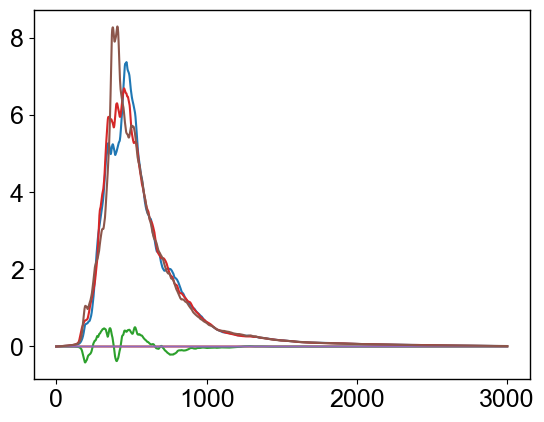

In [3]:
row = df['rel_permittivity_imag'].iloc[4]
for i in range(3):
    for j in range(i, 3):
        plt.plot(row[:,i,j])

plt.show()
df.to_pickle(data_file)


In [4]:
from e3nn.o3 import wigner_D, Irrep
from e3nn.io import CartesianTensor

import torch
T = torch.tensor([
    [1.0, 0.0, 0.7],
    [0.0, 0.9, 0.0],
    [0.7, 0.0, 0.8],
])  # shape (3, 3)
perm = torch.tensor([1, 2, 0])
# Step 2: Make sure it’s symmetric

T_perm = T.index_select(0, perm).index_select(1, perm)

x = CartesianTensor("ij=ji")

sph_perm = x.from_cartesian(T_perm)
sph = x.from_cartesian(T)
print(sph_perm)
print(sph)


tensor([ 1.5588,  0.0000,  0.0000, -0.1225,  0.9899,  0.0707])
tensor([ 1.5588e+00,  9.8995e-01,  0.0000e+00,  1.1102e-16,  0.0000e+00,
        -1.4142e-01])


In [5]:
from e3nn.o3 import wigner_D, Irrep
from e3nn.io import CartesianTensor

import torch
T = torch.tensor([
    [1.0, 0.3, 0.7],
    [0.3, 0.9, 0.5],
    [0.7, 0.5, 0.8],
])  # shape (3, 3)
perm = torch.tensor([1, 2, 0])
# Step 2: Make sure it’s symmetric

T_perm = T.index_select(0, perm).index_select(1, perm)

x = CartesianTensor("ij=ji")

sph_perm = x.from_cartesian(T_perm)
sph = x.from_cartesian(T)
print(sph_perm)
print(sph)


tensor([ 1.5588,  0.4243,  0.7071, -0.1225,  0.9899,  0.0707])
tensor([ 1.5588e+00,  9.8995e-01,  4.2426e-01,  1.1102e-16,  7.0711e-01,
        -1.4142e-01])


# ORIGINAL METHOD

(1432, 3001, 6)
9.747923918265228


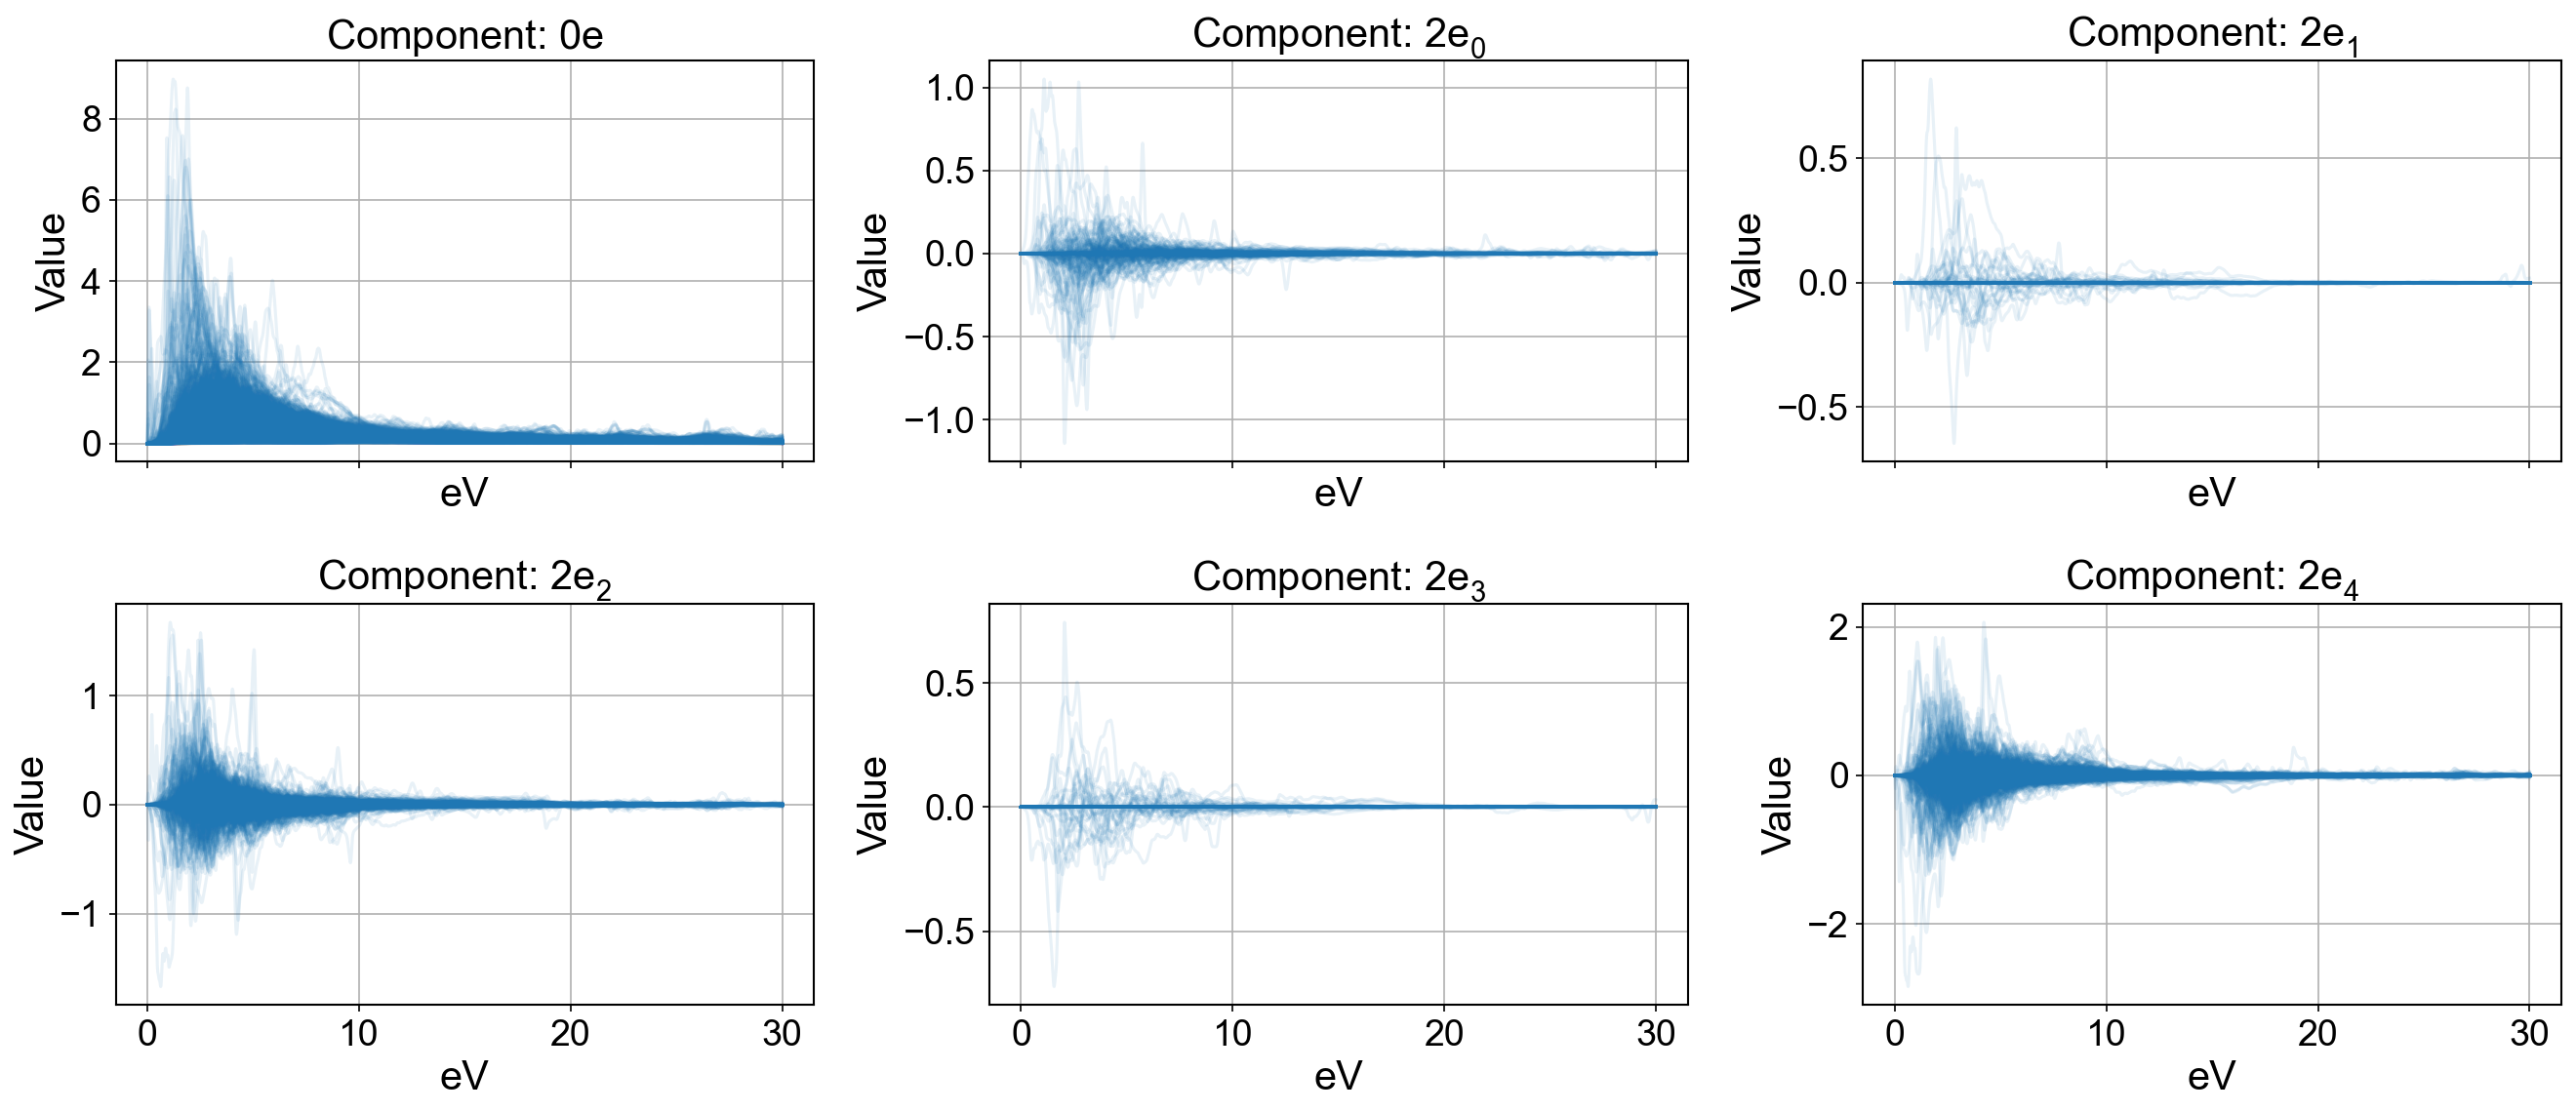

In [6]:
stack_matrices_tensor = torch.tensor(np.stack(df['rel_permittivity_imag'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 301, 3, 3)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # Shape: (num_samples, 301, 6)
df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

# Find the scaling value
tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print(tmp.shape)
scale_data = np.median(np.max(np.abs(tmp), axis=(1, 2)))
print(scale_data)

# Labels (optional)
channel_labels = ["0e", "2e_0", "2e_1", "2e_2", "2e_3", "2e_4"]

# Frequency axis
freqs = np.linspace(0, 30, 3001)  # replace with your actual energy or omega grid
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.plot(freqs, sph_coefs_tensor[:, :, i].T.cpu().numpy()/scale_data, alpha=0.1, color='C0')  # each sample = one line
    ax.set_title(rf"Component: ${channel_labels[i]}$")
    ax.set_xlabel("eV")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout()
plt.show()



# NEW NORM METHOD

tensor(87.4408, device='cuda:0') tensor(32.1951, device='cuda:0')


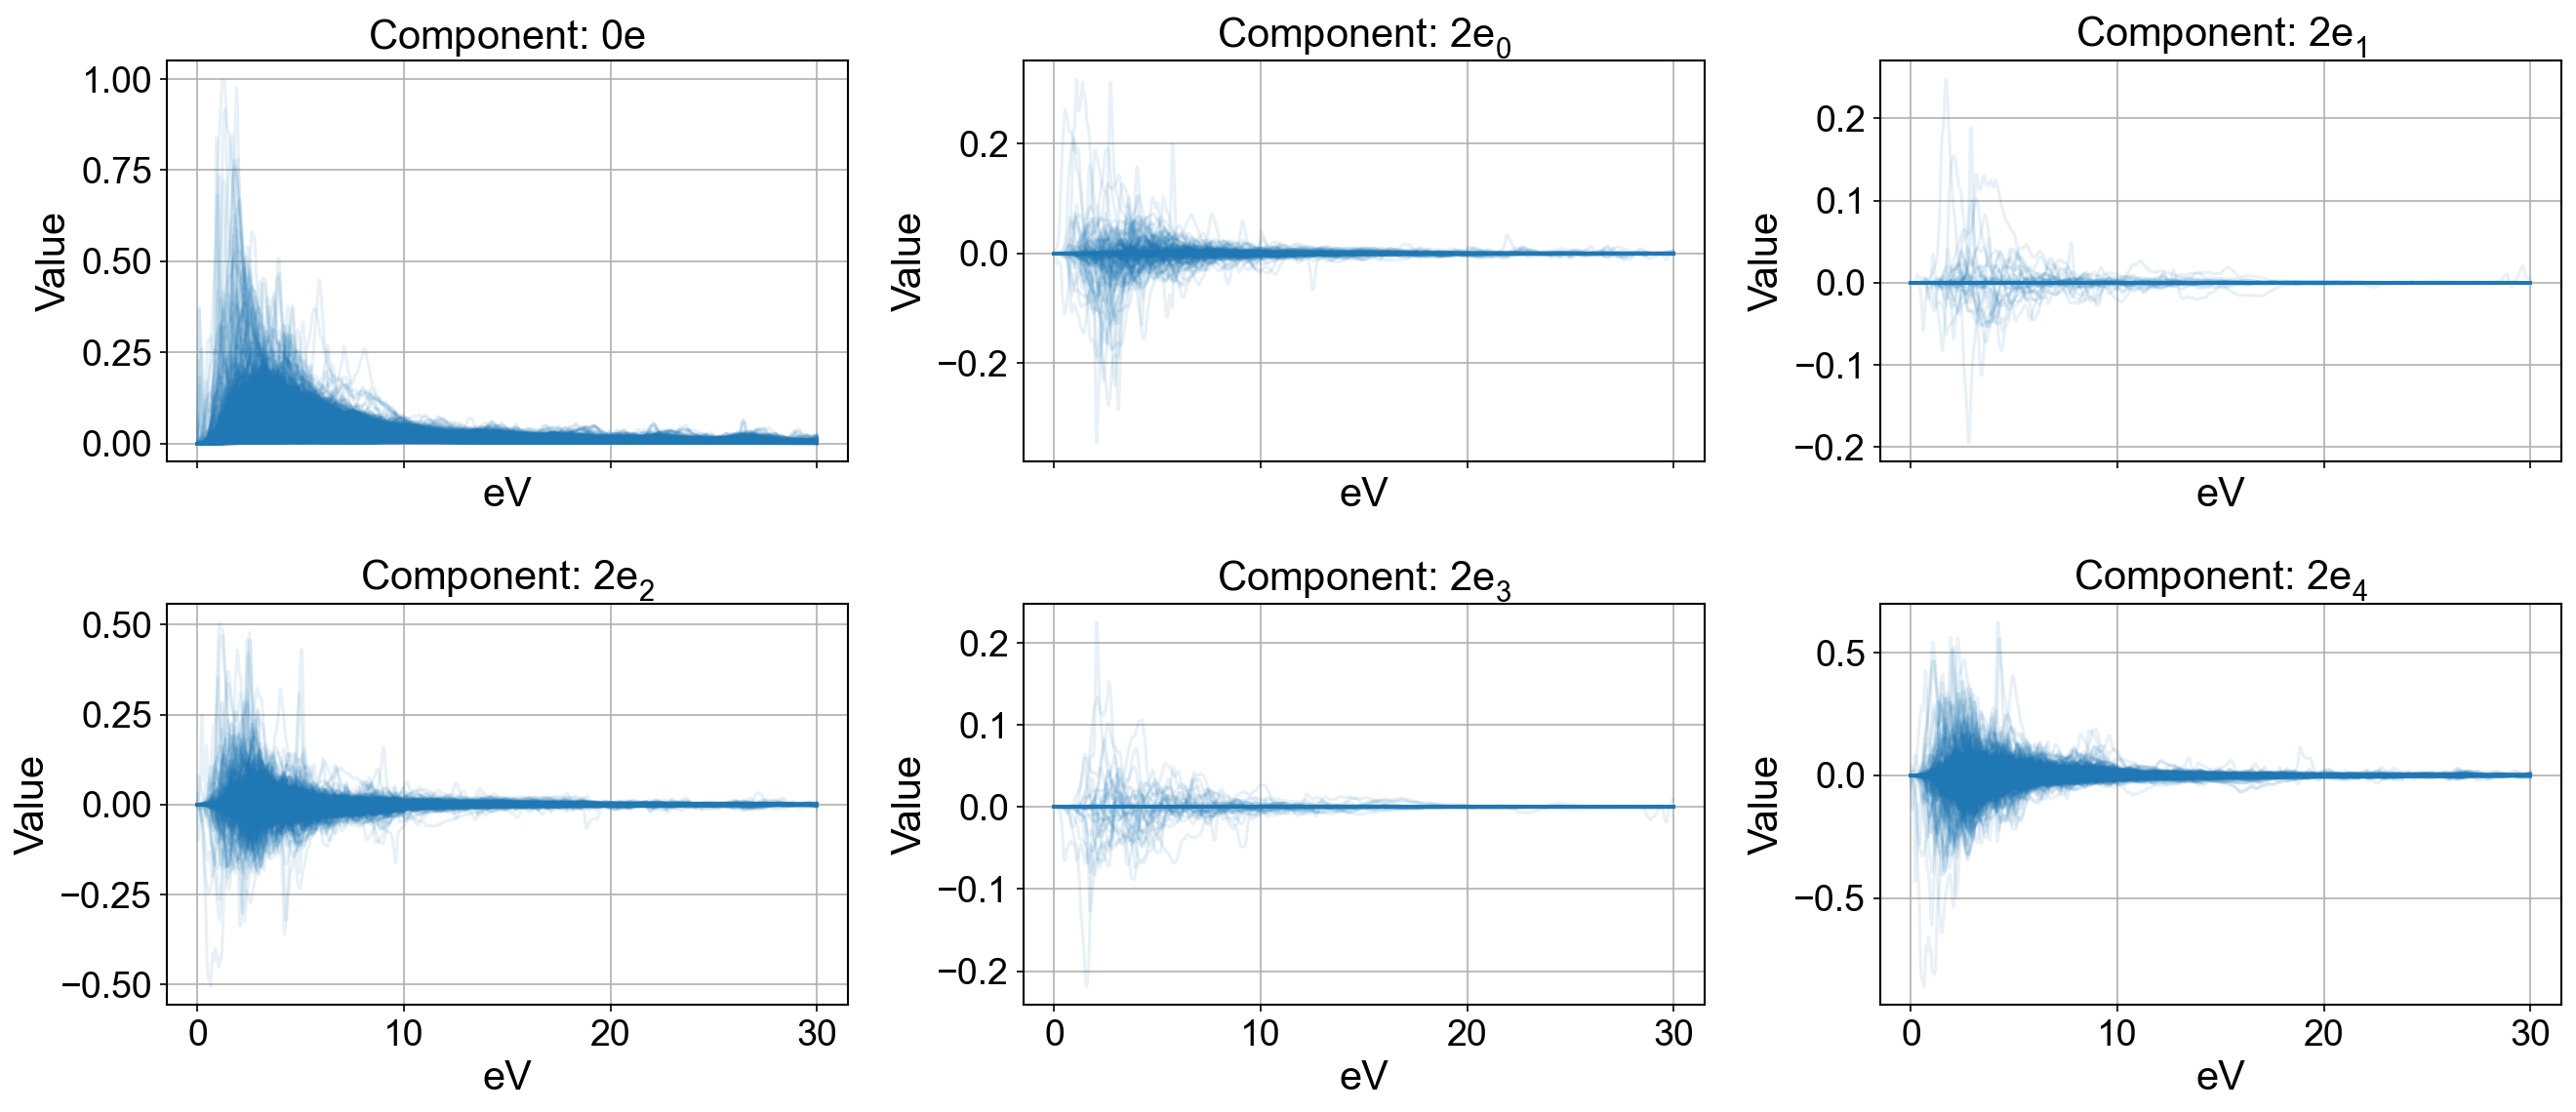

In [7]:
# Transform Cartesian tensor to irreps
stack_matrices_tensor = torch.tensor(np.stack(df['rel_permittivity_imag'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 301, 3, 3)
# Convert Cartesian to irreps (0e + 2e) with shape (N, F, 6)
x = CartesianTensor("ij=ji")
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # (N, F, 6)

# Separate 0e and 2e parts
scalar_0e = sph_coefs_tensor[:, :, 0]     # (N, F)
tensor_2e = sph_coefs_tensor[:, :, 1:]    # (N, F, 5)

# === Option 1: Global max normalization (simple, safe) ===
scale_0e = torch.max(torch.abs(scalar_0e))                        # scalar
scale_2e = torch.max(torch.norm(tensor_2e, dim=-1))               # scalar

# === Option 2: Global median-of-max normalization (robust to outliers) ===
# scale_0e = torch.median(torch.max(torch.abs(scalar_0e), dim=1).values)
# scale_2e = torch.median(torch.max(torch.norm(tensor_2e, dim=-1), dim=1).values)

# === Option 3: Normalize per sample, return scale arrays (preserves equivariance per sample) ===
# scale_0e = torch.max(torch.abs(scalar_0e), dim=1, keepdim=True).values   # (N, 1)
# scale_2e = torch.max(torch.norm(tensor_2e, dim=-1), dim=1, keepdim=True).values  # (N, 1)

# === Normalize ===
scalar_0e /= (scale_0e + 1e-12)
tensor_2e /= (scale_2e.unsqueeze(-1) + 1e-12)
print(scale_0e, scale_2e)
# Merge back
sph_coefs_tensor = torch.cat([scalar_0e.unsqueeze(-1), tensor_2e], dim=-1)  # (N, F, 6)

# Save to DataFrame
df["sph_coefs"] = list(sph_coefs_tensor.cpu().numpy())


# Labels (optional)
channel_labels = ["0e", "2e_0", "2e_1", "2e_2", "2e_3", "2e_4"]

# Frequency axis
freqs = np.linspace(0, 30, 3001)  # replace with your actual energy or omega grid
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.plot(freqs, sph_coefs_tensor[:, :, i].T.cpu().numpy(), alpha=0.1, color='C0')  # each sample = one line
    ax.set_title(rf"Component: ${channel_labels[i]}$")
    ax.set_xlabel("eV")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# import matplotlib.pyplot as plt

# # Labels (optional)
# channel_labels = ["0e", "2e_0", "2e_1", "2e_2", "2e_3", "2e_4"]

# # Frequency axis
# freqs = np.linspace(0, 30, 3001)  # replace with your actual energy or omega grid
# # Plotting
# fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
# axes = axes.flatten()


# for i in range(6):
#     ax = axes[i]
#     ax.plot(freqs, tmp[:, :, i].T/scale_data, alpha=0.1, color='C0')  # each sample = one line
#     ax.set_title(rf"Component: ${channel_labels[i]}$")
#     ax.set_xlabel("eV")
#     ax.set_ylabel("Value")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()


(1432, 3001, 6)
scale_data (per spherical channel): [9.68213104e+00 1.19788548e-21 3.74339213e-23 1.32394336e+00
 5.61508820e-23 1.95127270e+00]


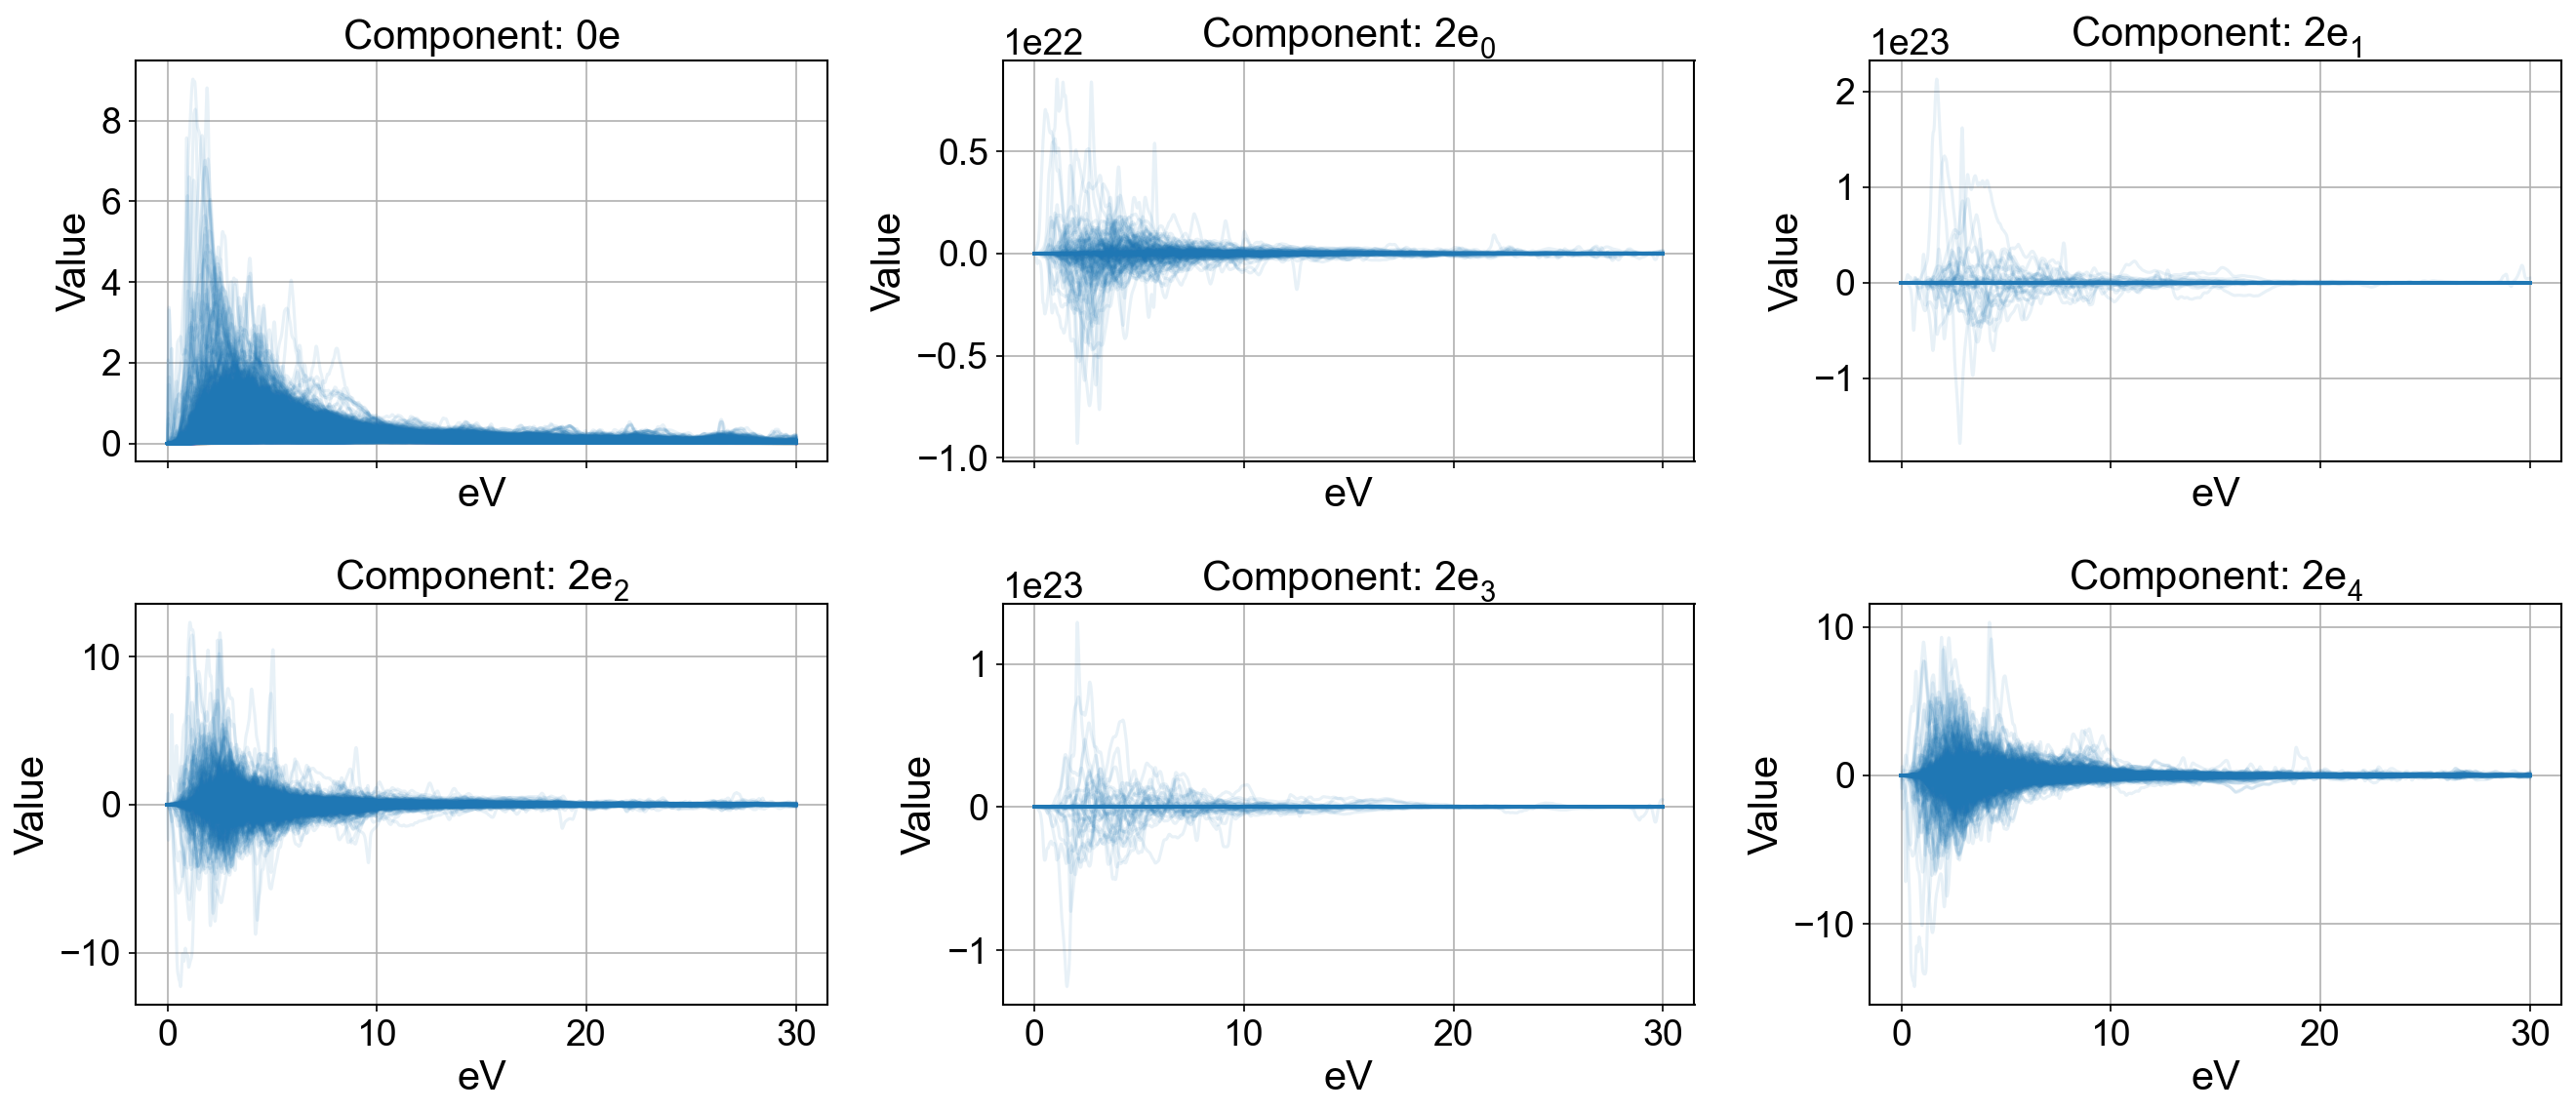

In [9]:
# Transform Cartesian tensor to irreps
stack_matrices_tensor = torch.tensor(np.stack(df['rel_permittivity_imag'].values), dtype=torch.float64, device=device)  # Shape: (num_samples, 301, 3, 3)

x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)  # Shape: (num_samples, 301, 6)
df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
print(tmp.shape)
max_abs_per_sample = torch.max(torch.abs(sph_coefs_tensor), dim=1).values  # (N, 6)
scale_data = torch.median(max_abs_per_sample, dim=0).values  # (6,), still on device

print("scale_data (per spherical channel):", scale_data.cpu().numpy())

sph_normalized = sph_coefs_tensor / scale_data.view(1, 1, 6)  # broadcast over (N, F, 6)
# Labels (optional)
channel_labels = ["0e", "2e_0", "2e_1", "2e_2", "2e_3", "2e_4"]
# Frequency axis
freqs = np.linspace(0, 30, 3001)  # replace with your actual energy or omega grid
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.plot(freqs, sph_normalized[:,:,i].T.cpu().numpy(), alpha=0.1, color='C0')  # each sample = one line
    ax.set_title(rf"Component: ${channel_labels[i]}$")
    ax.set_xlabel("eV")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout()
plt.show()


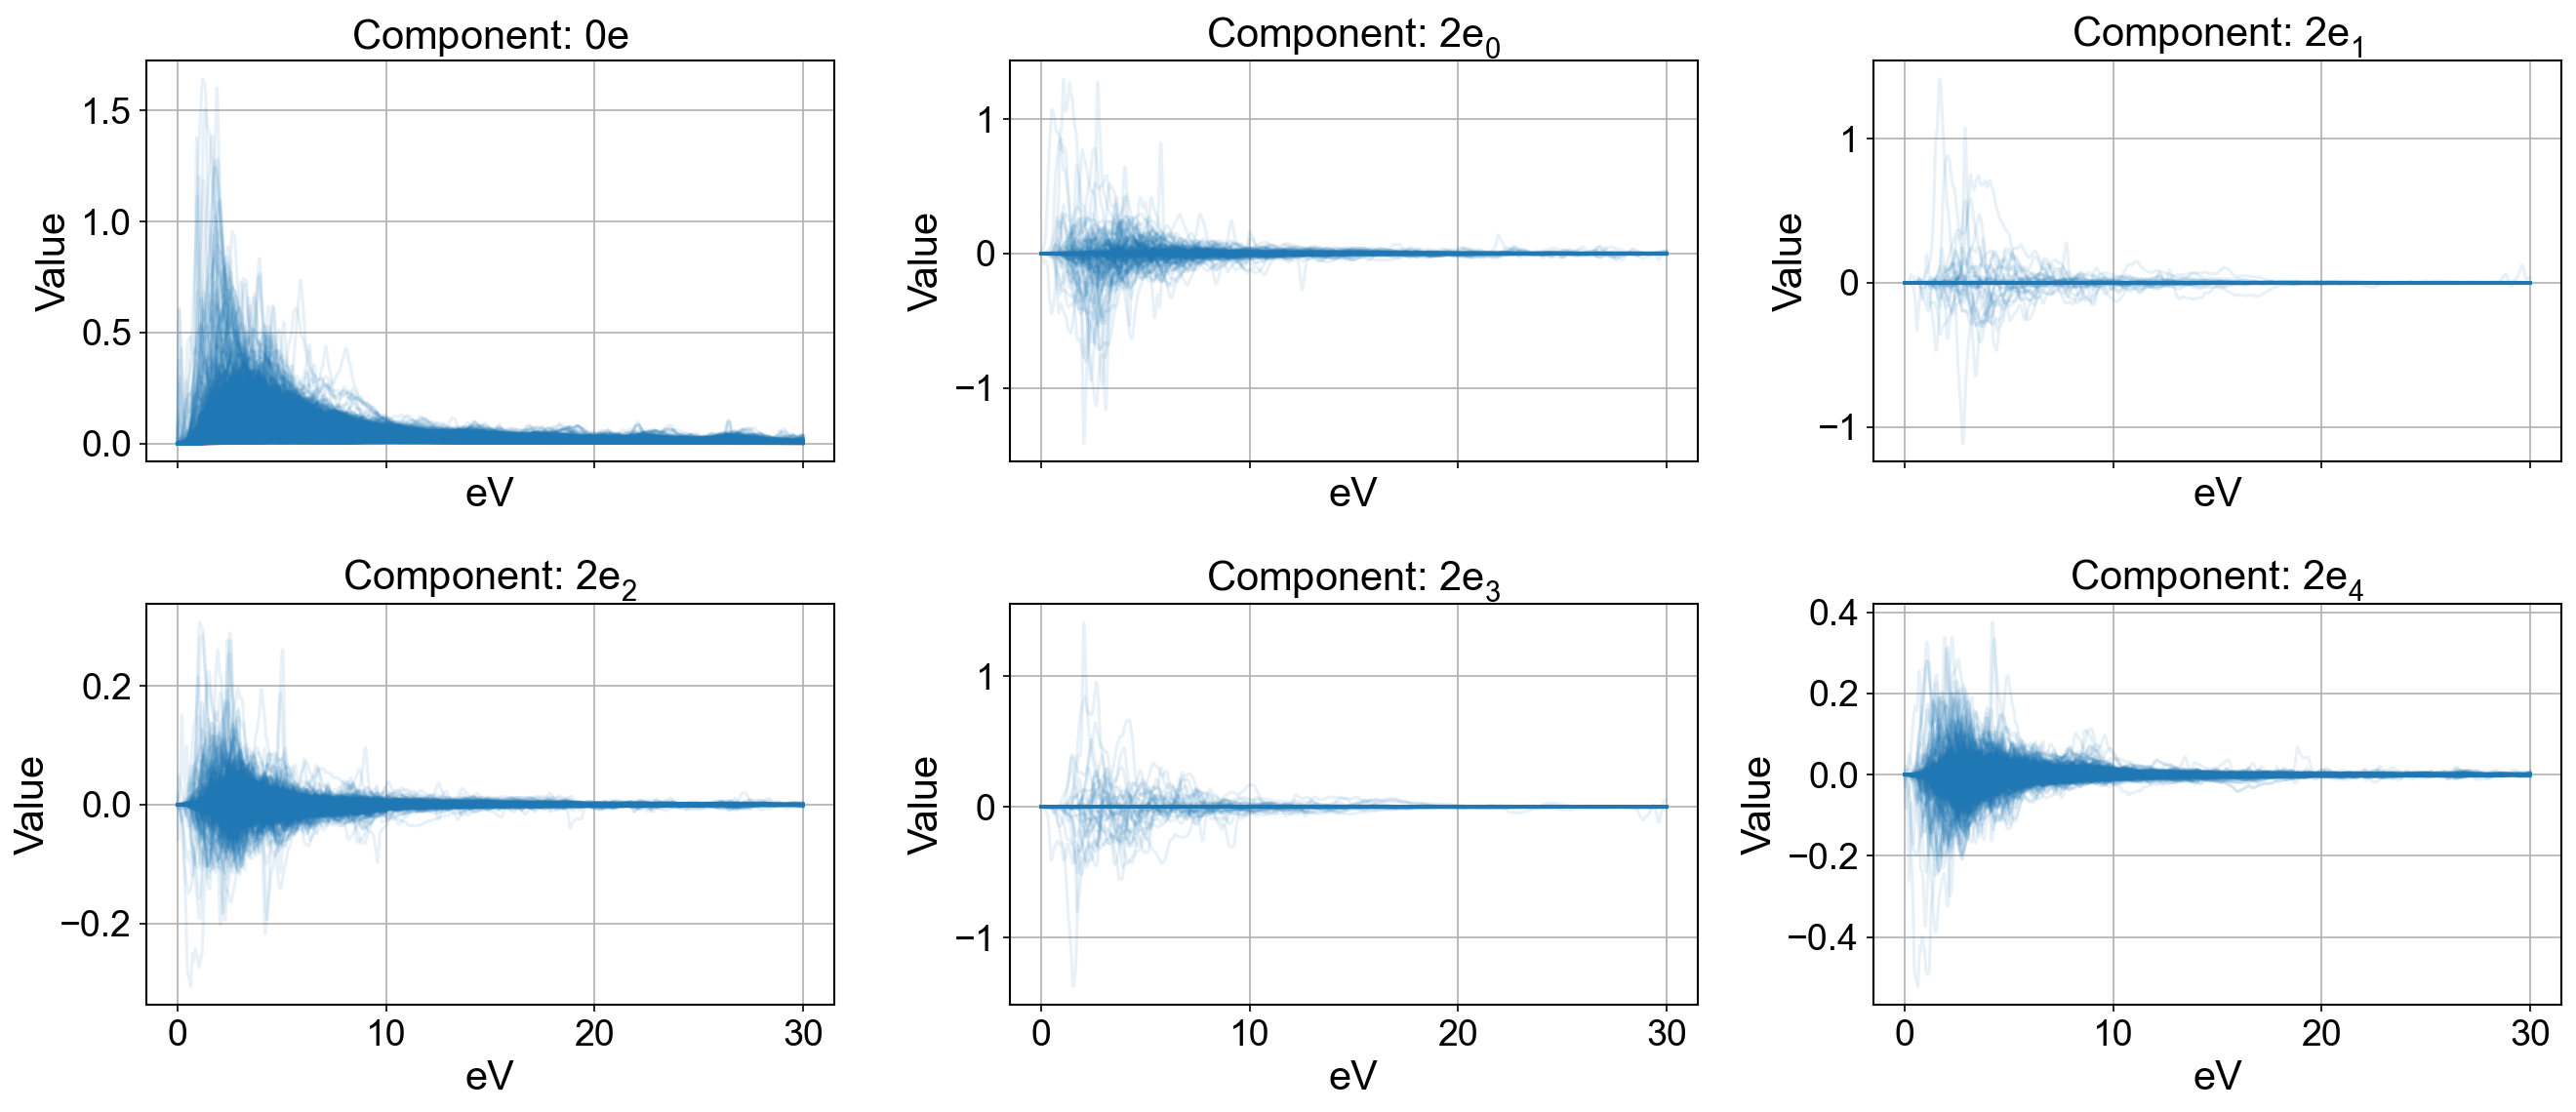

In [10]:
# Step 1: Stack into tensor (N, F, 3, 3)
cart_tensor = torch.tensor(
    np.stack(df['rel_permittivity_imag'].values),
    dtype=torch.float64,
    device=device
)  # shape: (N, F, 3, 3)

# Step 2: Compute normalization factors per Cartesian (i,j) component
# Reshape to (N*F, 3, 3) for easy reduction
cart_reshaped = cart_tensor.view(-1, 3, 3)  # shape: (N*F, 3, 3)

# Compute max-abs per entry (3,3)
max_abs_per_ij = torch.amax(torch.abs(cart_reshaped), dim=0)  # shape: (3, 3)

# Use median across all samples if preferred:
# max_abs_per_ij = torch.median(torch.abs(cart_reshaped), dim=0).values

# Avoid divide-by-zero
max_abs_per_ij = max_abs_per_ij + 1e-12

# Step 3: Normalize the Cartesian tensor
cart_normalized = cart_tensor / max_abs_per_ij.view(1, 1, 3, 3)  # broadcast over N, F

# Step 4: Convert to spherical after normalization
x = CartesianTensor("ij=ji")
sph_coefs_tensor = x.from_cartesian(cart_normalized)  # (N, F, 6)

# Optional: Store in DataFrame
# df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())
# Labels (optional)
channel_labels = ["0e", "2e_0", "2e_1", "2e_2", "2e_3", "2e_4"]
# Frequency axis
freqs = np.linspace(0, 30, 3001)  # replace with your actual energy or omega grid
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    ax.plot(freqs, sph_coefs_tensor[:,:,i].T.cpu().numpy(), alpha=0.1, color='C0')  # each sample = one line
    ax.set_title(rf"Component: ${channel_labels[i]}$")
    ax.set_xlabel("eV")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout()
plt.show()


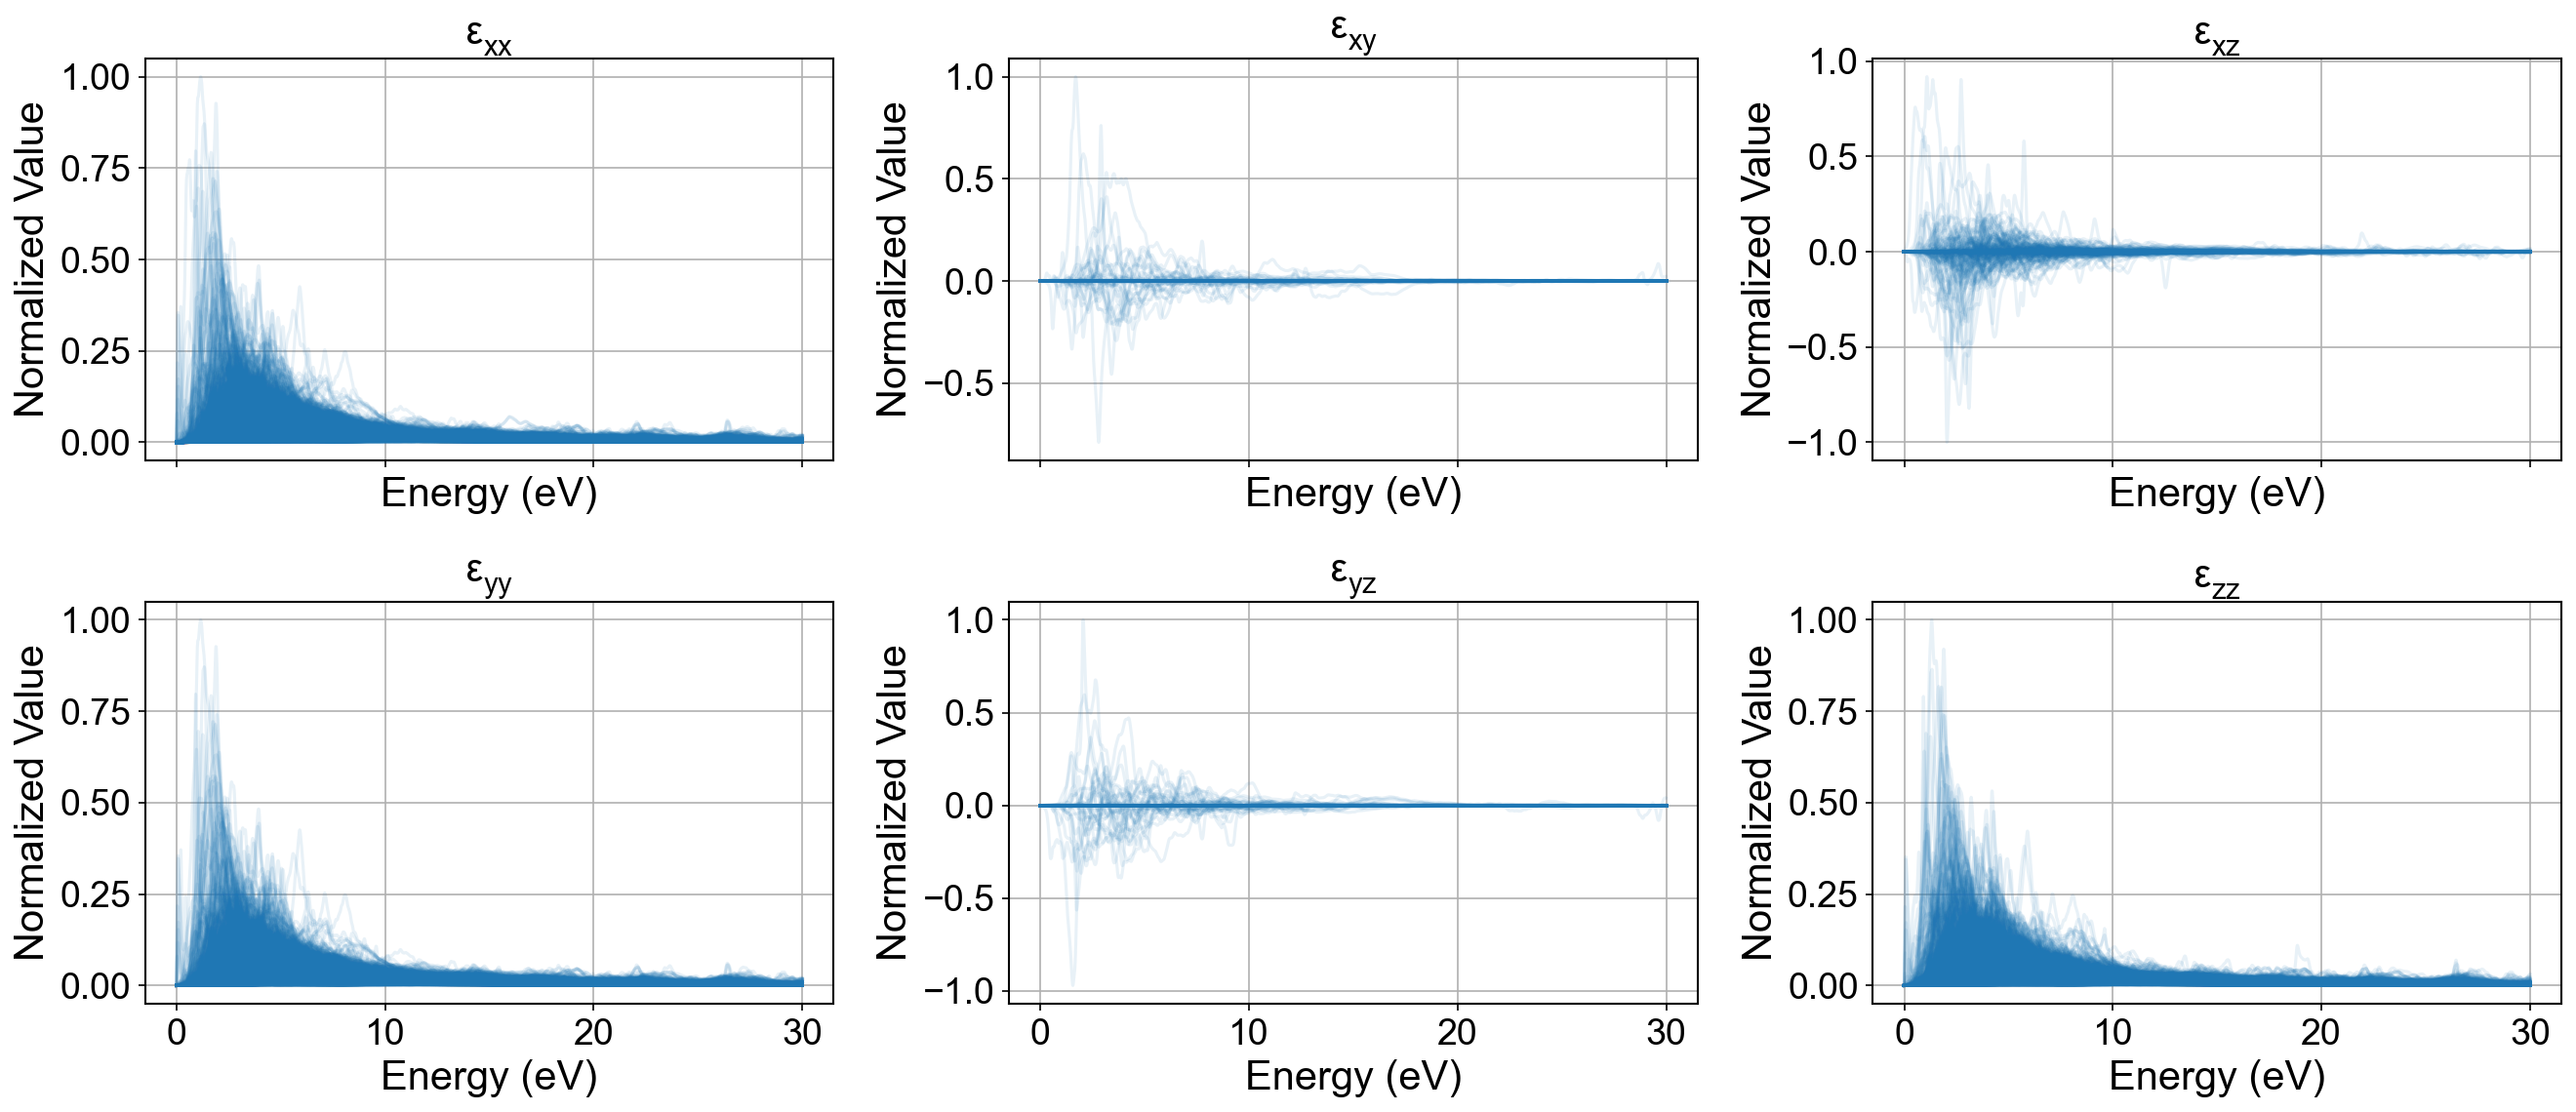

In [16]:
# Define component names
xyz = ['x', 'y', 'z']
channel_labels = [f"{xyz[i]}{xyz[j]}" for i in range(3) for j in range(i, 3)]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=150, sharex=True)
axes = axes.flatten()

# Loop through each symmetric component (i, j) with i <= j
plot_idx = 0
for i in range(3):
    for j in range(i, 3):
        ax = axes[plot_idx]
        ax.plot(freqs, cart_normalized[:, :, i, j].T.cpu().numpy(), alpha=0.1, color='C0')  # each sample = one line
        ax.set_title(rf"$\epsilon_{{{xyz[i]}{xyz[j]}}}$")
        ax.set_xlabel("Energy (eV)")
        ax.set_ylabel("Normalized Value")
        ax.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()
